# Ник aminovrustam, позиция 8

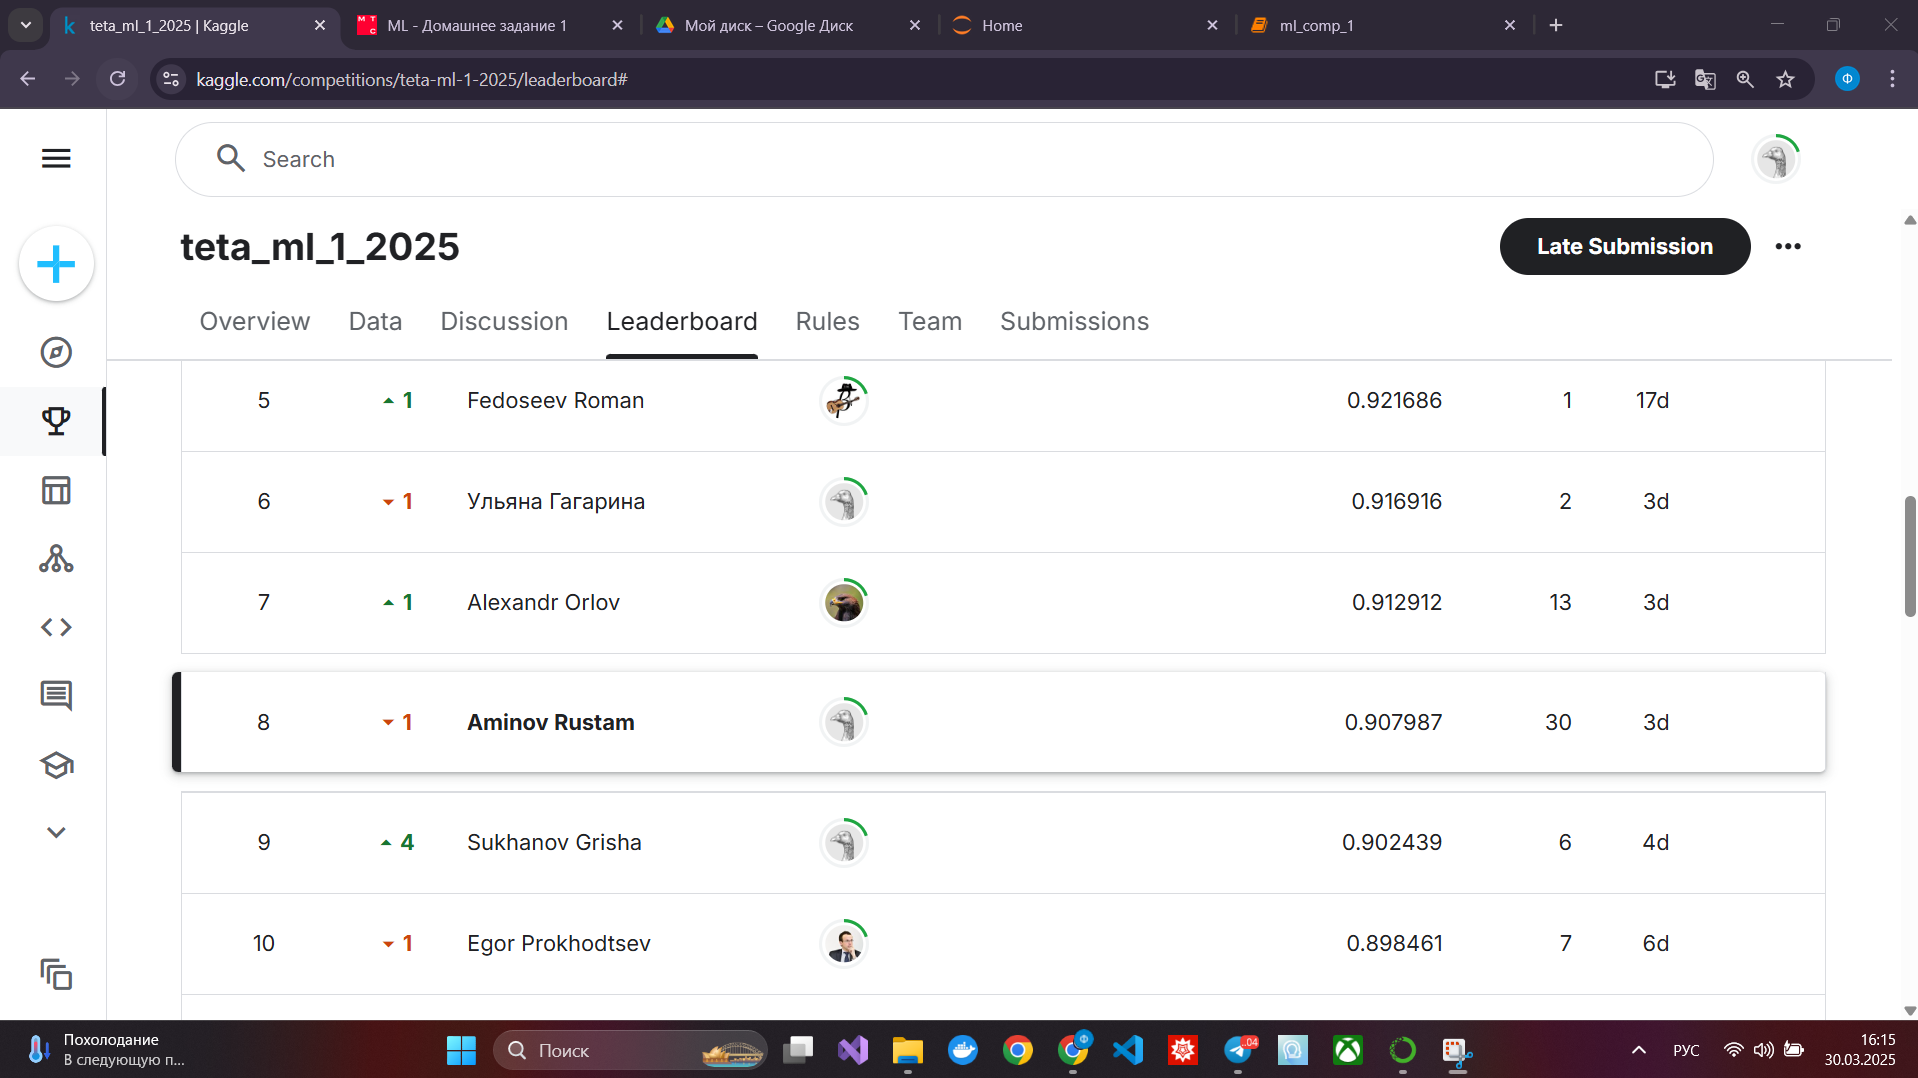

# Intro

1) **Обработка данных**:
Первым делом я проверил данные на наличие пропусков. Далее я посмторел дисбаланс классов. После этого я проверил непрерывные признаки на наличие выбросов при помощи zscore. Добавил новые признаки:
    - Я решил выделить несколько крупных городов в США и добавил фичи, связанные с их координатами - Нью-Йорк, Даллас, Орландо и Денвер
        - *bearing_degree_(1/2/3)* - угол между прямой ((lat, lon),(merchant_lat, merchant_lon))/ ((lat, lon),(0, 0))/ ((0, 0),(merchant_lat, merchant_lon)) и нулевой меридианой
        - *bearing_degree_NY_(1/2)* - угол между прямой ((lat, lon), (NY_coord[0], NY_coord[1]))/ ((NY_coord[0], NY_coord[1]),(merchant_lat, merchant_lon)) и нулевой меридианой, где *NY_coord* - координаты Нью-Йорка
        - *bearing_degree_DA_(1/2)* - угол между прямой ((lat, lon), (DA_coord[0], DA_coord[1]))/ ((DA_coord[0], DA_coord[1]),(merchant_lat, merchant_lon)) и нулевой меридианой, где *DA_coord* - координаты Далласа
        - *bearing_degree_ORL_(1/2)* - угол между прямой ((lat, lon), (ORL_coord[0], ORL_coord[1]))/ ((ORL_coord[0], ORL_coord[1]),(merchant_lat, merchant_lon)) и нулевой меридианой, где *ORL_coord* - координаты Орландо
        - *bearing_degree_DV_(1/2)* - угол между прямой ((lat, lon), (DV_coord[0], DV_coord[1]))/ ((DV_coord[0], DV_coord[1]),(merchant_lat, merchant_lon)) и нулевой меридианой, где *DV_coord* - координаты Денвера
        - *hav_dist_(1/2/3)* - расстояние от точки (lat, lon)/(lat, lon)/(0, 0) до точки (merchant_lat, merchant_lon)/(0, 0)/(merchant_lat, merchant_lon) по прямой
        - *hav_dist_NY_(1/2)* - расстояние от (lat, lon)/(merchant_lat, merchant_lon) до Нью-Йорка по прямой
        - *hav_dist_DA_(1/2)* - расстояние от (lat, lon)/(merchant_lat, merchant_lon) до Далласа по прямой
        - *hav_dist_ORL_(1/2)* - расстояние от (lat, lon)/(merchant_lat, merchant_lon) до Орландо по прямой
        - *hav_dist_DV_(1/2)* - расстояние от (lat, lon)/(merchant_lat, merchant_lon) до Денвера по прямой
    - Я решил добавить признаки, касающиеся времени совершения транзакции
        - *times_of_day* - категориальный признак, определяющий днем была совершена транзакция или нет
        - *weekends* - категориальный признак, определяющий транзакция была произведена в выходной или нет 
        - *month* - категориальный признак, определяющий месяц, когда была произведена транзакция
          
    После этого я использовал алгоритм *backward_selection* для определения признаков, которые можно удалить для улучшения показателя f1_score.

2) **Алгоритм**:
Я выбрал модель *CatBoostClassifier*. Также *CatBoostClassifier* предоставляет возможность автоматической обработки категориальных признаков, что снижает шанс ошибиться при их ручном кодировании и в целом упрощает работу с моделью. После чего организовал ансамбль из 7 моделей, обученных на разных объектах выборки разделенных посредством *StratifiedKFold*. Сохранил лучшие трешхолды и далее устраивал между моделями голосование. Голосовал двумя способами:

   - Формировал 7 столбцов с ответами моделей, после чего формировал столбец с конечным ответом по принципу: если единиц больше, чем нулей, то ответ единица, если же нулей, то ноль
    - Формировал 7 столбцов с вероятностью принадлежания ответа к единице, далее используя лучшие трешхолды формировал бинарные ответи, а далее выбирал из них лучшие по принципу предыдущего голосования
   
    Ансамбль с голосованием из моделей *CatBoostClassifier* на тестовой выборке и на сабмите показал результаты лучше чем одна модель при одинаковых гиперпараметрах, так же я считаю, что благодаря разным обучающим выборкам ансамбль лучше справляется с переобучением, чем единичная модель, поэтому я выбрал ансамбль. Из-за возможности выбирать два сабмита на финальный лидерборд я решил оставить эти два голосования и не выбирать из них лучший.

4) **Особенности при обучении**:
Я использовал возможность *CatBoostClassifier* автоматической обработки категориальных признаков. Коэффициент регуляризации *L2* 0.1 и *learning_rate* 0.1.

5) **Валидация алгоритма**:
После обучение ансамбля брал тестовую выборку из тренировочной и смотрел значение метрики f1_score между таргетом из этой тестовой выборки и ответами, которые получились после голосования ансамбля (отложенная выборка).

# Загрузка данных

In [3]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns
import mplcyberpunk
plt.style.use("cyberpunk")

In [8]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [12]:
train.head(1)

,transaction_time,merch,cat_id,amount,name_1,name_2,gender,street,one_city,us_state,post_code,lat,lon,population_city,jobs,merchant_lat,merchant_lon,target
0,2019-12-27 15:21,fraud_Cormier LLC,health_fitness,148.04,Daniel,Martinez,M,8510 Acevedo Burgs,Kent,OR,97033,45.0838,-120.6649,60,Museum education officer,45.042827,-120.709327,0


# Обработка данных

## Проверка на пропуски

In [4]:
print(f'Пропуски в обучающей выборке: {train.isna().sum().sum()}, пропуски в тестовой выборке: {test.isna().sum().sum()}')

Пропуски в обучающей выборке: 0, пропуски в тестовой выборке: 0


Мошенников: 4504, не мошенников: 781927


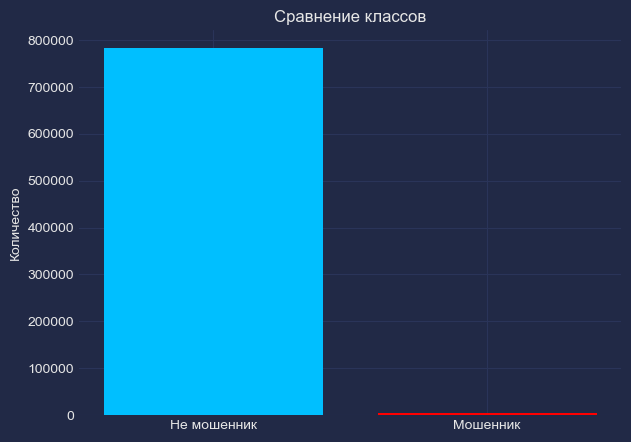

In [64]:
print(f'Мошенников: {train['target'].value_counts()[1]}, не мошенников: {train['target'].value_counts()[0]}')
plt.figure(figsize=(7, 5))

categories = ['Не мошенник', 'Мошенник']

values = [train['target'].value_counts()[0], train['target'].value_counts()[1]]
colors=['#00BFFF', 'red']

plt.bar(categories, values, color=colors, zorder=2)
plt.ylabel('Количество')
plt.title('Сравнение классов')
plt.grid(True)

## Проверка на выбросы

Добавлю колонку ts_transaction_time, чтобы выразить время транзакции численно

In [41]:
train['ts_transaction_time'] = pd.to_datetime(train['transaction_time']).values.astype('int64') // 10**9
test['ts_transaction_time'] = pd.to_datetime(test['transaction_time']).values.astype('int64') // 10**9

In [42]:
num_columns=train.drop(columns='target').select_dtypes(['int32', 'int64', 'float64']).columns

In [43]:
num_columns

Index(['amount', 'post_code', 'lat', 'lon', 'population_city', 'merchant_lat',
       'merchant_lon', 'ts_transaction_time'],
      dtype='object')

amount Обучающая выборка 7614 Тестирующая выборка 2694


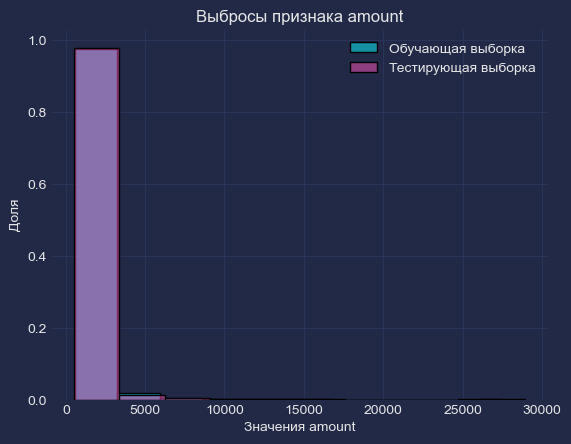

lat Обучающая выборка 2804 Тестирующая выборка 940


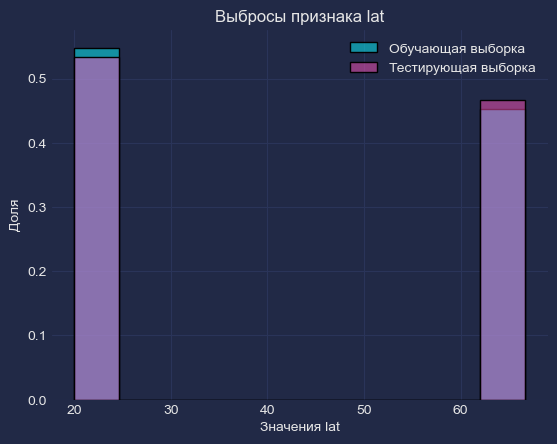

lon Обучающая выборка 2804 Тестирующая выборка 940


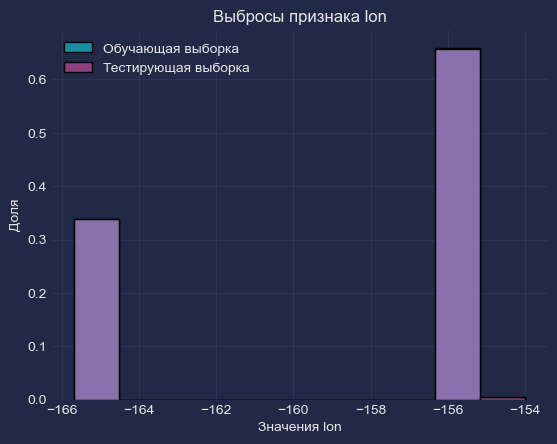

population_city Обучающая выборка 20039 Тестирующая выборка 6572


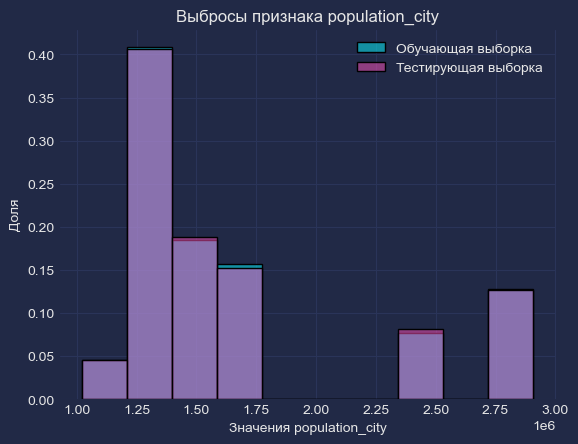

merchant_lat Обучающая выборка 2804 Тестирующая выборка 940


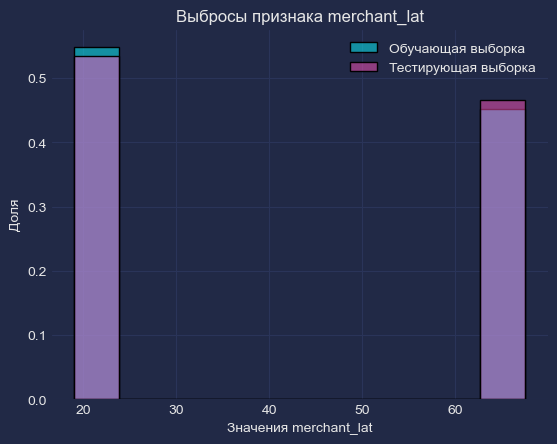

merchant_lon Обучающая выборка 2804 Тестирующая выборка 940


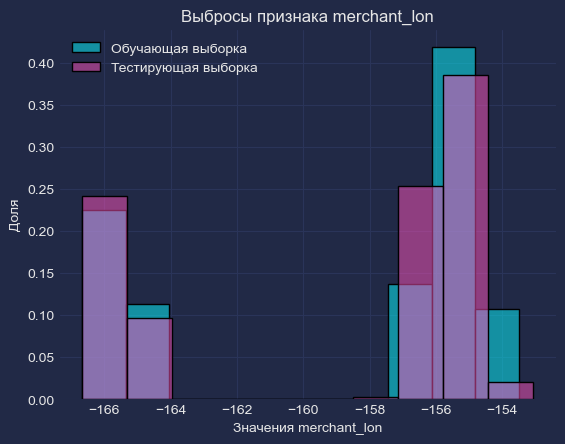

In [44]:
for column in num_columns:
    mask_outliesr_train = np.abs(zscore(train[column].values)) >= 3
    mask_outliesr_test = np.abs(zscore(test[column].values)) >= 3

    if(sum(mask_outliesr_train)!=0 and sum(mask_outliesr_test) != 0):
        print(
          column,
          'Обучающая выборка', sum(mask_outliesr_train),
          'Тестирующая выборка', sum(mask_outliesr_test),
        )
    
        sns.histplot(train[mask_outliesr_train][column], stat="probability", bins=10, alpha=0.5, label='Обучающая выборка')
        sns.histplot(test[mask_outliesr_test][column], stat="probability", bins=10, alpha=0.5, label='Тестирующая выборка')
        plt.legend()
        plt.ylabel('Доля')
        plt.xlabel(f'Значения {column}')
        plt.title(f'Выбросы признака {column}')
        plt.show()

In [45]:
for column in num_columns:
    mask_outliesr_train = np.abs(zscore(train[column].values)) >= 3
    mask_outliesr_test = np.abs(zscore(test[column].values)) >= 3

    if(sum(mask_outliesr_train)==0 and sum(mask_outliesr_test) == 0):
        print(f'В признаке {column} нет выбросов')
        

В признаке post_code нет выбросов
В признаке ts_transaction_time нет выбросов


**Вывод:** Как видно выбросы есть, однако их распределения по train и test схожи

# Новые фичи

## Геоданные

In [78]:
def haversine_distance(lat1: float, lon1: float, lat2: float, lon2: float, n_digits: int = 0) -> float:
    """
        Функция для расчёта расстояния от точки А до Б по прямой

        :param lat1: Широта точки А
        :param lon1: Долгота точки А
        :param lat2: Широта точки Б
        :param lon2: Долгота точки Б
        :param n_digits: Округляем полученный ответ до n знака после запятой
        :return: Дистанция по прямой с точностью до n_digits
    """

    lat1, lon1, lat2, lon2 = round(lat1, 6), round(lon1, 6), round(lat2, 6), round(lon2, 6)
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)

    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi / 2) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda / 2) ** 2

    return round(2 * 6372800 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)), n_digits)  # метры.сантиметры


def bearing_degree(lat1: float, lon1: float, lat2: float, lon2: float, n_digits: int = 0) -> float:
    """
        Функция для расчёта угла между прямой [((lat1, lon1), (lat2, lon2)), (нулевой мередиан)]

        :param lat1: Широта точки А
        :param lon1: Долгота точки А
        :param lat2: Широта точки Б
        :param lon2: Долгота точки Б
        :param n_digits: Округляем полученный ответ до n знака после запятой
        :return: Значение угла с точностью до n_digits
    """

    lat1, lon1 = np.radians(round(lat1, 6)), np.radians(round(lon1, 6))
    lat2, lon2 = np.radians(round(lat2, 6)), np.radians(round(lon2, 6))

    dlon = (lon2 - lon1)
    numerator = np.sin(dlon) * np.cos(lat2)
    denominator = np.cos(lat1) * np.sin(lat2) - (np.sin(lat1) * np.cos(lat2) * np.cos(dlon))

    theta = np.arctan2(numerator, denominator)
    theta_deg = (np.degrees(theta) + 360) % 360

    return round(theta_deg, n_digits)

In [79]:
NY_coord = [40.7143, -74.006]
DA_coord = [32.7831, -96.8067]
ORL_coord = [32.7831, -96.8067]
DV_coord = [41.5236, -90.5776]

In [80]:
train['bearing_degree_1'] = bearing_degree(train['lat'], train['lon'], train['merchant_lat'], train['merchant_lon'], ).values
test['bearing_degree_1'] = bearing_degree(test['lat'], test['lon'], test['merchant_lat'], test['merchant_lon'], ).values

train['bearing_degree_2'] = bearing_degree(train['lat'], train['lon'], 0, 0, ).values
test['bearing_degree_2'] = bearing_degree(test['lat'], test['lon'], 0, 0, ).values

train['bearing_degree_3'] = bearing_degree(0, 0, train['merchant_lat'], train['merchant_lon'], ).values
test['bearing_degree_3'] = bearing_degree(0, 0, test['merchant_lat'], test['merchant_lon'], ).values

train['bearing_degree_NY_1'] = bearing_degree(train['lat'], train['lon'], NY_coord[0], NY_coord[1], ).values
test['bearing_degree_NY_1'] = bearing_degree(test['lat'], test['lon'], NY_coord[0], NY_coord[1], ).values

train['bearing_degree_NY_2'] = bearing_degree(NY_coord[0], NY_coord[1], train['merchant_lat'], train['merchant_lon'], ).values
test['bearing_degree_NY_2'] = bearing_degree(NY_coord[0], NY_coord[1], test['merchant_lat'], test['merchant_lon'], ).values

train['bearing_degree_DA_1'] = bearing_degree(train['lat'], train['lon'], DA_coord[0], DA_coord[1], ).values
test['bearing_degree_DA_1'] = bearing_degree(test['lat'], test['lon'], DA_coord[0], DA_coord[1], ).values

train['bearing_degree_DA_2'] = bearing_degree(DA_coord[0], DA_coord[1], train['merchant_lat'], train['merchant_lon'], ).values
test['bearing_degree_DA_2'] = bearing_degree(DA_coord[0], DA_coord[1], test['merchant_lat'], test['merchant_lon'], ).values

train['bearing_degree_ORL_1'] = bearing_degree(train['lat'], train['lon'], ORL_coord[0], ORL_coord[1], ).values
test['bearing_degree_ORL_1'] = bearing_degree(test['lat'], test['lon'], ORL_coord[0], ORL_coord[1], ).values

train['bearing_degree_ORL_2'] = bearing_degree(ORL_coord[0], ORL_coord[1], train['merchant_lat'], train['merchant_lon'], ).values
test['bearing_degree_ORL_2'] = bearing_degree(ORL_coord[0], ORL_coord[1], test['merchant_lat'], test['merchant_lon'], ).values

train[' '] = bearing_degree(train['lat'], train['lon'], DV_coord[0], DV_coord[1], ).values
test['bearing_degree_DV_1'] = bearing_degree(test['lat'], test['lon'], DV_coord[0], DV_coord[1], ).values

train['bearing_degree_DV_2'] = bearing_degree(DV_coord[0], DV_coord[1], train['merchant_lat'], train['merchant_lon'], ).values
test['bearing_degree_DV_2'] = bearing_degree(DV_coord[0], DV_coord[1], test['merchant_lat'], test['merchant_lon'], ).values

In [81]:
train['hav_dist_1'] = haversine_distance(train['lat'], train['lon'], train['merchant_lat'], train['merchant_lon'], ).values
test['hav_dist_1'] = haversine_distance(test['lat'], test['lon'], test['merchant_lat'], test['merchant_lon'], ).values

train['hav_dist_2'] = haversine_distance(train['lat'], train['lon'], 0, 0, ).values
test['hav_dist_2'] = haversine_distance(test['lat'], test['lon'], 0, 0, ).values

train['hav_dist_3'] = haversine_distance(0, 0, train['merchant_lat'], train['merchant_lon'], ).values
test['hav_dist_3'] = haversine_distance(0, 0, test['merchant_lat'], test['merchant_lon'], ).values

train['hav_dist_NY_1'] = haversine_distance(train['lat'], train['lon'], NY_coord[0], NY_coord[1], ).values
test['hav_dist_NY_1'] = haversine_distance(test['lat'], test['lon'], NY_coord[0], NY_coord[1], ).values

train['hav_dist_NY_2'] = haversine_distance(NY_coord[0], NY_coord[1], train['merchant_lat'], train['merchant_lon'], ).values
test['hav_dist_NY_2'] = haversine_distance(NY_coord[0], NY_coord[1], test['merchant_lat'], test['merchant_lon'], ).values

train['hav_dist_DA_1'] = haversine_distance(train['lat'], train['lon'], DA_coord[0], DA_coord[1], ).values
test['hav_dist_DA_1'] = haversine_distance(test['lat'], test['lon'], DA_coord[0], DA_coord[1], ).values

train['hav_dist_DA_2'] = haversine_distance(DA_coord[0], DA_coord[1], train['merchant_lat'], train['merchant_lon'], ).values
test['hav_dist_DA_2'] = haversine_distance(DA_coord[0], DA_coord[1], test['merchant_lat'], test['merchant_lon'], ).values

train['hav_dist_ORL_1'] = haversine_distance(train['lat'], train['lon'], ORL_coord[0], ORL_coord[1], ).values
test['hav_dist_ORL_1'] = haversine_distance(test['lat'], test['lon'], ORL_coord[0], ORL_coord[1], ).values

train['hav_dist_ORL_2'] = haversine_distance(ORL_coord[0], ORL_coord[1], train['merchant_lat'], train['merchant_lon'], ).values
test['hav_dist_ORL_2'] = haversine_distance(ORL_coord[0], ORL_coord[1], test['merchant_lat'], test['merchant_lon'], ).values

train['hav_dist_DV_1'] = haversine_distance(train['lat'], train['lon'], DV_coord[0], DV_coord[1], ).values
test['hav_dist_DV_1'] = haversine_distance(test['lat'], test['lon'], DV_coord[0], DV_coord[1], ).values

train['hav_dist_DV_2'] = haversine_distance(DV_coord[0], DV_coord[1], train['merchant_lat'], train['merchant_lon'], ).values
test['hav_dist_DV_2'] = haversine_distance(DV_coord[0], DV_coord[1], test['merchant_lat'], test['merchant_lon'], ).values

## Работа со временем

In [82]:
# функция узнающая день сейчас или нет
def day_night(hour):
  if hour >= 6 and hour < 18:
    return 'D'
  else:
    return 'N'

train['time'] = pd.to_datetime(train['transaction_time'])
test['time'] = pd.to_datetime(test['transaction_time'])

train['times_of_day'] = train['time'].dt.hour.apply(day_night)
test['times_of_day'] = test['time'].dt.hour.apply(day_night)

In [83]:
def is_weekend(day_of_week):
    return 'W' if day_of_week >= 5 else 'NW'

train['weekends'] = train['time'].dt.dayofweek.apply(is_weekend)
test['weekends'] = test['time'].dt.dayofweek.apply(is_weekend)

In [84]:
monthes = {
    1: 'jan',
    2: 'f',
    3: 'm',
    4: 'a',
    5: 'my',
    6: 'in',
    7: 'j',
    8: 'av',
    9: 's',
    10: 'o',
    11: 'n',
    12: 'd'
}

In [85]:
def w_month(month):
  return monthes[month]

train['month'] = train['time'].dt.month.apply(w_month)
test['month'] = test['time'].dt.month.apply(w_month)

# Тест модели и features importance

In [86]:
cat_columns = [
    'merch', 'cat_id', 'name_1', 'name_2', 'gender', 'street', 'one_city',
    'us_state', 'post_code', 'jobs', 'month', 'times_of_day', 'weekends'
]

In [87]:
fin_mod_features = ['amount',
 'bearing_degree_1',
 'bearing_degree_2',
 'bearing_degree_3',
 'bearing_degree_NY_1',
 'bearing_degree_DA_1',
 'bearing_degree_ORL_1',
 'bearing_degree_DV_1',
 'bearing_degree_NY_2',
 'bearing_degree_DA_2',
 'bearing_degree_ORL_2',
 'bearing_degree_DV_2',
 'hav_dist_1',
 'hav_dist_2',
 'hav_dist_3',
 'hav_dist_NY_1',
 'hav_dist_DA_1',
 'hav_dist_ORL_1',
 'hav_dist_DV_1',
 'hav_dist_NY_2',
 'hav_dist_DA_2',
 'hav_dist_ORL_2',
 'hav_dist_DV_2',
 'lat',
 'lon',
 'merchant_lat',
 'merchant_lon',
 'population_city',
  'merch', 'cat_id', 'name_1', 'name_2', 'gender', 'street', 'one_city',
    'us_state', 'post_code', 'jobs', 'month', 'times_of_day', 'weekends'
]

In [88]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [89]:
X_train, X_test, y_train, y_test = train_test_split(
    train[fin_mod_features], train['target'], test_size=0.25, random_state=42,
    stratify=train['target']
)

In [98]:
model = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=5, random_state=14, custom_metric='F1', l2_leaf_reg=0.1)

model.fit(X_train, y_train, cat_features=cat_columns, eval_set=(X_test, y_test))

0:	learn: 0.4119838	test: 0.4119409	best: 0.4119409 (0)	total: 389ms	remaining: 6m 28s
1:	learn: 0.2758279	test: 0.2757570	best: 0.2757570 (1)	total: 778ms	remaining: 6m 28s
2:	learn: 0.1811200	test: 0.1810790	best: 0.1810790 (2)	total: 1.17s	remaining: 6m 28s
3:	learn: 0.1248050	test: 0.1247911	best: 0.1247911 (3)	total: 1.55s	remaining: 6m 26s
4:	learn: 0.0902537	test: 0.0902666	best: 0.0902666 (4)	total: 1.94s	remaining: 6m 26s
5:	learn: 0.0647448	test: 0.0648552	best: 0.0648552 (5)	total: 2.3s	remaining: 6m 20s
6:	learn: 0.0461528	test: 0.0462445	best: 0.0462445 (6)	total: 2.7s	remaining: 6m 22s
7:	learn: 0.0352853	test: 0.0352874	best: 0.0352874 (7)	total: 3.1s	remaining: 6m 24s
8:	learn: 0.0277789	test: 0.0277333	best: 0.0277333 (8)	total: 3.63s	remaining: 6m 39s
9:	learn: 0.0230371	test: 0.0229443	best: 0.0229443 (9)	total: 4.1s	remaining: 6m 45s
10:	learn: 0.0210076	test: 0.0208999	best: 0.0208999 (10)	total: 4.47s	remaining: 6m 42s
11:	learn: 0.0188857	test: 0.0182771	best: 0.

In [99]:
model.get_best_score()

{'learn': {'F1': 0.9224002513352183, 'Logloss': 0.003230581986528875},
 'validation': {'F1': 0.8905589478628464, 'Logloss': 0.004539260101606262}}

## Backward selection для определения признаков, которые можно удалить

In [70]:
def backward_selection(X, y, tol=0.01):
    """
    Реализация алгоритма обратного исключения (backward selection)

    Алгоритм начинает со всеми признаками и последовательно удаляет наименее значимые,
    пока качество модели не перестанет улучшаться.
    """
    # Создаем копию данных
    X_copy = X.copy()
    cat_features = cat_columns.copy()
    # Разделяем данные на обучающую и тестовую выборки
    X_train, X_test, y_train, y_test = train_test_split(X_copy, y, test_size=0.3, random_state=42)

    # Создаем модель
    model = CatBoostClassifier(iterations=20, learning_rate=0.1, depth=5, silent=True)

    # Обучаем модель на всех признаках
    model.fit(X_train, y_train, cat_features=cat_features)
    y_pred = model.predict(X_test)
    best_score = f1_score(y_test, y_pred)

    print(f"Начальная точность (все признаки): {best_score:.4f}")

    # Список всех признаков
    all_features = list(X_train.columns)
    best_features = all_features.copy()

    # Итеративно удаляем признаки
    while len(all_features) > 1:
        temp_score = []
        temp_features = []

        # Проверяем каждый признак
        for feature in all_features:

            # Создаем набор данных без текущего признака
            temp_X_train = X_train.drop(feature, axis=1)
            temp_X_test = X_test.drop(feature, axis=1)
            
            if feature in cat_features:
                cat_features.remove(feature)
            # Создаем новую модель
            temp_model = CatBoostClassifier(iterations=20, learning_rate=0.1, depth=5, silent=True)

            # Обучаем модель
            temp_model.fit(temp_X_train, y_train, cat_features=cat_features)
            temp_y_pred = temp_model.predict(temp_X_test)
            temp_score.append(f1_score(y_test, temp_y_pred))
            temp_features.append(feature)
            if feature in cat_columns:
                cat_features.append(feature)
        # Находим признак, удаление которого дает наилучший результат
        max_score_idx = np.argmax(temp_score)

        # Если удаление признака улучшает или не ухудшает модель
        if temp_score[max_score_idx] >= best_score - tol:
            # Обновляем лучший результат
            best_score = temp_score[max_score_idx]
            # Удаляем признак из списка
            feature_to_remove = temp_features[max_score_idx]
            all_features.remove(feature_to_remove)
            best_features.remove(feature_to_remove)
            print(f"Удален признак: {feature_to_remove}, новая точность: {best_score:.4f}")
        else:
            # Если удаление любого признака ухудшает модель, останавливаемся
            break

    print(f"Лучший набор признаков: {best_features}")
    print(f"Лучшая точность: {best_score:.4f}")

    return best_features

In [16]:
backward_selection(train[fin_mod_features], train['target'], tol=0.001)

Начальная точность (все признаки): 0.5883
['merch', 'cat_id', 'name_1', 'name_2', 'gender', 'street', 'one_city', 'us_state', 'post_code', 'jobs', 'month', 'times_of_day', 'weekends']
['merch', 'cat_id', 'name_1', 'name_2', 'gender', 'street', 'one_city', 'us_state', 'post_code', 'jobs', 'month', 'times_of_day', 'weekends']
['merch', 'cat_id', 'name_1', 'name_2', 'gender', 'street', 'one_city', 'us_state', 'post_code', 'jobs', 'month', 'times_of_day', 'weekends']
['merch', 'cat_id', 'name_1', 'name_2', 'gender', 'street', 'one_city', 'us_state', 'post_code', 'jobs', 'month', 'times_of_day', 'weekends']
['merch', 'cat_id', 'name_1', 'name_2', 'gender', 'street', 'one_city', 'us_state', 'post_code', 'jobs', 'month', 'times_of_day', 'weekends']
['merch', 'cat_id', 'name_1', 'name_2', 'gender', 'street', 'one_city', 'us_state', 'post_code', 'jobs', 'month', 'times_of_day', 'weekends']
['merch', 'cat_id', 'name_1', 'name_2', 'gender', 'street', 'one_city', 'us_state', 'post_code', 'jobs', '

['amount',
 'bearing_degree_1',
 'bearing_degree_2',
 'bearing_degree_3',
 'bearing_degree_NY_1',
 'bearing_degree_DA_1',
 'bearing_degree_ORL_1',
 'bearing_degree_DV_1',
 'bearing_degree_NY_2',
 'bearing_degree_DA_2',
 'bearing_degree_ORL_2',
 'hav_dist_1',
 'hav_dist_2',
 'hav_dist_3',
 'hav_dist_NY_1',
 'hav_dist_DA_1',
 'hav_dist_ORL_1',
 'hav_dist_DV_1',
 'hav_dist_NY_2',
 'hav_dist_DA_2',
 'hav_dist_ORL_2',
 'hav_dist_DV_2',
 'lat',
 'lon',
 'merchant_lat',
 'merchant_lon',
 'population_city',
 'merch',
 'cat_id',
 'name_1',
 'name_2',
 'gender',
 'street',
 'one_city',
 'us_state',
 'post_code',
 'jobs',
 'month',
 'times_of_day',
 'weekends']

In [92]:
fin_with_search=['amount',
 'bearing_degree_1',
 'bearing_degree_2',
 'bearing_degree_3',
 'bearing_degree_NY_1',
 'bearing_degree_DA_1',
 'bearing_degree_ORL_1',
 'bearing_degree_DV_1',
 'bearing_degree_NY_2',
 'bearing_degree_DA_2',
 'bearing_degree_ORL_2',
 'hav_dist_1',
 'hav_dist_2',
 'hav_dist_3',
 'hav_dist_NY_1',
 'hav_dist_DA_1',
 'hav_dist_ORL_1',
 'hav_dist_DV_1',
 'hav_dist_NY_2',
 'hav_dist_DA_2',
 'hav_dist_ORL_2',
 'hav_dist_DV_2',
 'lat',
 'lon',
 'merchant_lat',
 'merchant_lon',
 'population_city',
 'merch',
 'cat_id',
 'name_1',
 'name_2',
 'gender',
 'street',
 'one_city',
 'us_state',
 'post_code',
 'jobs',
 'month',
 'times_of_day',
 'weekends']

# Модификация модели и организация ансамбля

In [15]:
from sklearn.model_selection import StratifiedKFold

Пробую без разделения

In [18]:
X = train[fin_with_search]
y = train['target']

Буду сохранять модели в список, а так же определять их лучшие трешхолды и сохранять их в список

In [93]:
models = []
skf = StratifiedKFold(n_splits=7)
skf.get_n_splits(X, y)
best_tresholds = []
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    
    X_tr = X.iloc[train_index]
    y_tr = y.iloc[train_index]

    X_te = X.iloc[test_index]
    y_te = y.iloc[test_index]

    
    temp_model = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=5, random_state=14, custom_metric='F1', l2_leaf_reg=0.1, silent=True)
    temp_model.fit(X_tr, y_tr, cat_features=cat_columns)
    
    pred = temp_model.predict_proba(X_te)
    pred=pred[:, 1]
    pred_bin = pred >= 0.29
    best_f1 = f1_score(y_te, pred_bin)
    best_trashhold = 0.29
    
    for trashold in np.arange(0.34, 0.99, 0.05):
        pred_bin = pred >= trashold
        if f1_score(y_te, pred_bin) > best_f1:
            best_f1 = f1_score(y_te, pred_bin)
            best_trashhold = trashold
    best_tresholds.append(best_trashhold)
    models.append(temp_model)
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")
    print(f"Best f1_score: {best_f1}, best_trash_hold: {best_trashhold}")

Fold 0:
  Train: index=[107124 107308 107963 ... 786428 786429 786430]
  Test:  index=[     0      1      2 ... 112378 112379 112380]
Best f1_score: 0.9106719367588932, best_trash_hold: 0.34
Fold 1:
  Train: index=[     0      1      2 ... 786428 786429 786430]
  Test:  index=[107124 107308 107963 ... 224744 224745 224746]
Best f1_score: 0.8948220064724919, best_trash_hold: 0.39
Fold 2:
  Train: index=[     0      1      2 ... 786428 786429 786430]
  Test:  index=[215929 215946 216315 ... 337074 337075 337076]
Best f1_score: 0.9063004846526656, best_trash_hold: 0.39
Fold 3:
  Train: index=[     0      1      2 ... 786428 786429 786430]
  Test:  index=[331049 331308 331683 ... 449402 449403 449404]
Best f1_score: 0.9030206677265501, best_trash_hold: 0.29
Fold 4:
  Train: index=[     0      1      2 ... 786428 786429 786430]
  Test:  index=[447677 447832 447860 ... 561768 561769 561770]
Best f1_score: 0.8946098149637972, best_trash_hold: 0.44
Fold 5:
  Train: index=[     0      1      2 

In [71]:
def models_fit(models, X_test):
    '''
    Функция для формирования семи столбцов с бинарными ответами
    '''
    res = []
    for model in models:
        res.append(model.predict(X_test))
    return np.array(res).T

In [72]:
def models_fit_proba(models, X_test):
    '''
    Функция для формирования семи столбцов с вероятностями принадлежности класса к единице
    '''
    res = []
    for model in models:
        res.append(model.predict_proba(X_test)[:, 1])
    return np.array(res).T

In [73]:
def golosovanie(predicts):
    '''
    Функция по принципу голосования единиц больше чем нулей, значит единица, иначе ноль
    '''
    res = []
    for predict in predicts:
        if np.sum(predict==0) > predict.shape[0]//2:
            res.append(0)
        else:
            res.append(1)
    return res

In [74]:
def convert_to_bin(predicts_proba, best_tresholds):
    '''
    Функция для конвертации вероятностных ответов к бинарным, используя сохраненные лучшие трешхолды
    '''
    res = []
    for predict in predicts_proba:
        bin_predict = predict > best_tresholds
        res.append(bin_predict)
    return np.array(res)

Тестирование и проверка показателей метрики f1_score

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    train[fin_with_search], train['target'], test_size=0.25, random_state=42,
    stratify=train['target']
)

Проверка обычного голосования

In [46]:
f1_score(y_test, golosovanie(models_fit(models, X_test)))

0.925

Проверка обычного голосования с использованием лучших трешхолдов

In [70]:
f1_score(y_test, golosovanie(convert_to_bin(models_fit_proba(models, X_test), best_tresholds)))

0.9283432222729348

# Выгрузка результатов

Выгрузка ответов голосования с лучшими трешхолдами

In [94]:
prred = golosovanie(convert_to_bin(models_fit_proba(models, test[fin_with_search]), best_tresholds))

In [95]:
sample = pd.read_csv('sample_submition.csv', index_col=0)

In [96]:
sample['prediction']=prred

In [97]:
sample.to_csv('output_attempt_with_ansamble_golosovanie_proba_best_tresh_(iter=1000).csv')

Выгрузка ответов обычного голосования

In [98]:
prred = golosovanie(models_fit(models, test[fin_with_search]))

In [99]:
sample = pd.read_csv('sample_submition.csv', index_col=0)

In [100]:
sample['prediction']=prred

In [101]:
sample.to_csv('output_attempt_with_ansamble_golosovanie(iter=1000).csv')

# Outro

**Как улучшить решение:**
1) Составить ансамбль из разных моделей, например CatBoostClassifier, LGBMClassifier, KNN... И добавить несколько дублирующихся с разными гиперпараметрами.
2) Добавить новые фичи, например:
    - Найти точку продажи по координатам, в радиусе которой больше всего мошеннических сделок и расчитать дя каждого образца расстояние от нее
    - Найти точку продажи по координатам, в радиусе которой меньше всего мошеннических сделок и расчитать дя каждого образца расстояние от нее
    - Для отдельного почтового индекса можно посчитать количество мошеннических сделок и обычных и сделать новый признак *post_code_trust* и заполнить значениями равными $\dfrac{\text{количество мошеннических сделок с этим индексом}}{\text{количество обычных сделок с этим индексом}+10^{-6}}$
    - Использовать эмбендинг/нейросеть для кодирования колонки *merch* в вектора и обучить с этими векторами ансамбль/модель
    - Использовать эмбендинг/нейросеть для кодирования колонки *jobs* в вектора и обучить с этими векторами ансамбль/модель
    - Добавить *id* для продавцов и так же, как и для почтвого индекса создать рейтинг для организаций по их индексу
    - Посчитать среднюю сумму покупки для штатов и сделать новый столбец, показывающий абсолютное значение разницы между средней стоимости покупки в штате и стоимости конкретной покупки/сделки $|x_i-\overline{x}|$, где $x_i$ - конкретная сделка, а $\overline{x}$-средняя покупка в этом штате
3) Подобрать гиперпараметры при помощи *hyperopt/optuna*